Loading data from /kaggle/input/environmental-sensor-data-132k/iot_telemetry_data.csv...
Dataset loaded successfully: 405184 records with 9 columns

Sample data:
             ts             device        co   humidity  light       lpg  \
0  1.594512e+09  b8:27:eb:bf:9d:51  0.004956  51.000000  False  0.007651   
1  1.594512e+09  00:0f:00:70:91:0a  0.002840  76.000000  False  0.005114   
2  1.594512e+09  b8:27:eb:bf:9d:51  0.004976  50.900000  False  0.007673   
3  1.594512e+09  1c:bf:ce:15:ec:4d  0.004403  76.800003   True  0.007023   
4  1.594512e+09  b8:27:eb:bf:9d:51  0.004967  50.900000  False  0.007664   

   motion     smoke       temp  
0   False  0.020411  22.700000  
1   False  0.013275  19.700001  
2   False  0.020475  22.600000  
3   False  0.018628  27.000000  
4   False  0.020448  22.600000  

Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405184 entries, 0 to 405183
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
-

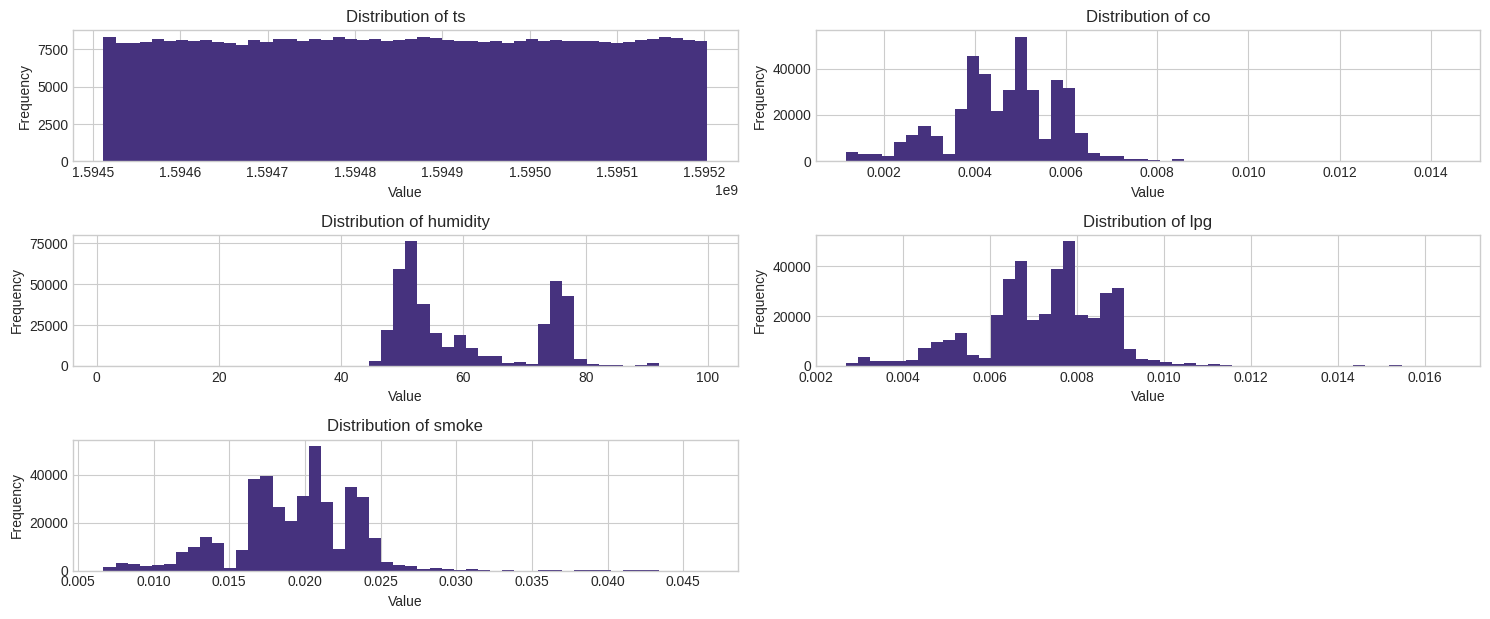

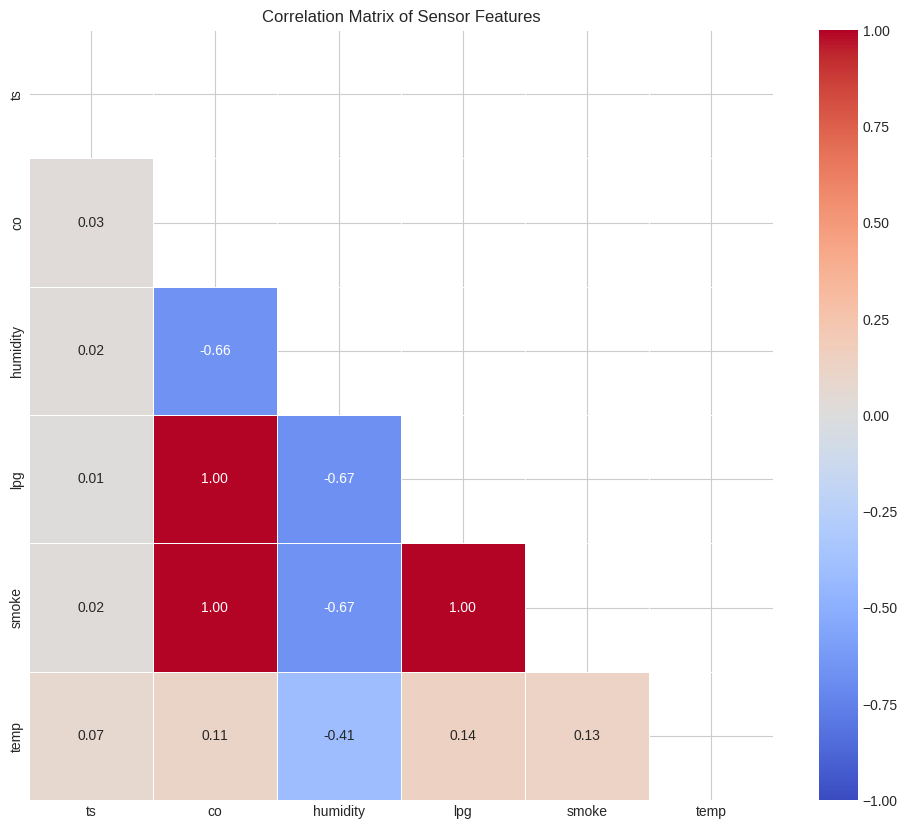


Basic statistics of sensor features:
                 ts             co       humidity            lpg  \
count  4.051840e+05  405184.000000  405184.000000  405184.000000   
mean   1.594858e+09       0.004639      60.511694       0.007237   
std    1.994984e+05       0.001250      11.366489       0.001444   
min    1.594512e+09       0.001171       1.100000       0.002693   
25%    1.594686e+09       0.003919      51.000000       0.006456   
50%    1.594858e+09       0.004812      54.900000       0.007489   
75%    1.595031e+09       0.005409      74.300003       0.008150   
max    1.595203e+09       0.014420      99.900002       0.016567   

               smoke           temp  
count  405184.000000  405184.000000  
mean        0.019264      22.453987  
std         0.004086       2.698347  
min         0.006692       0.000000  
25%         0.017024      19.900000  
50%         0.019950      22.200000  
75%         0.021838      23.600000  
max         0.046590      30.600000  

Detect

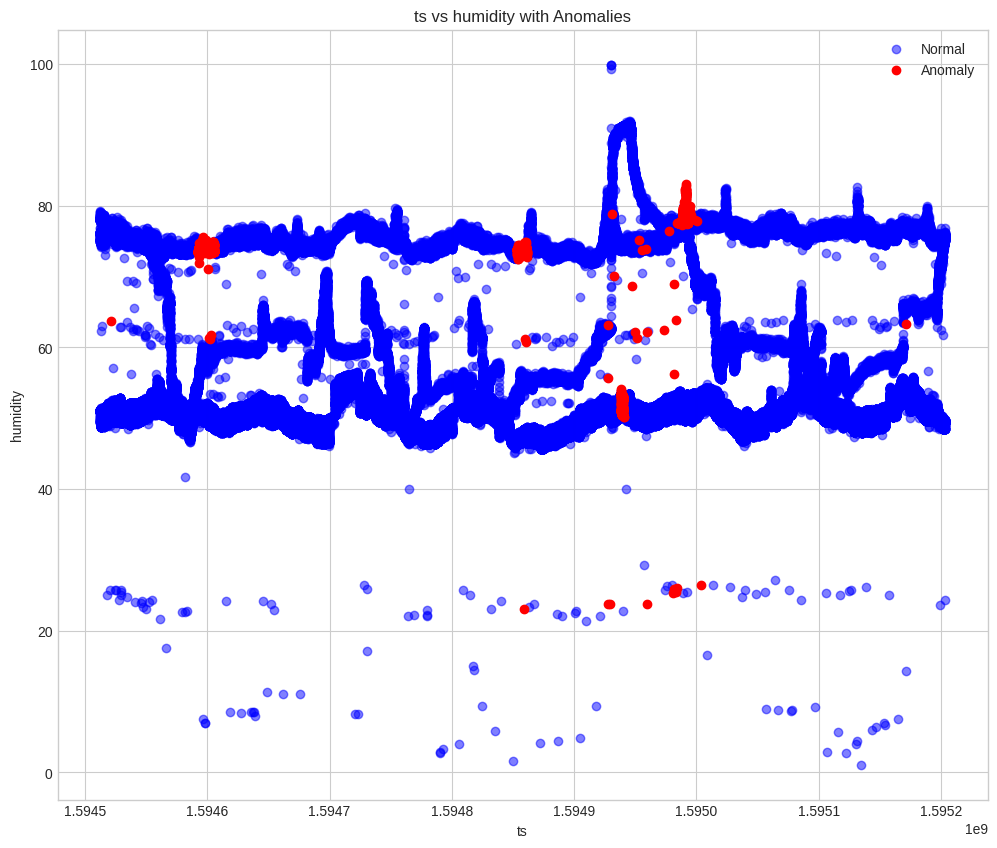

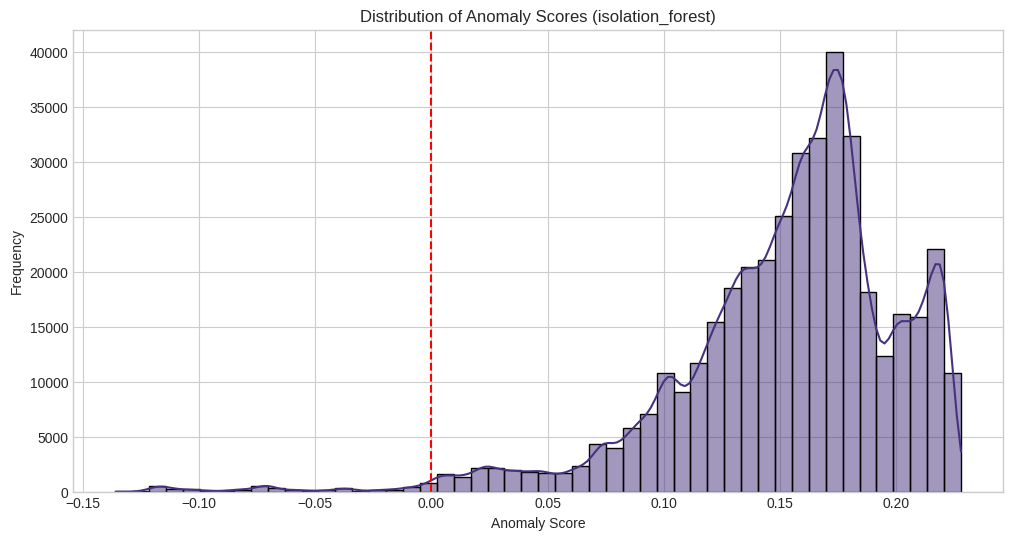

Generating PCA visualization...


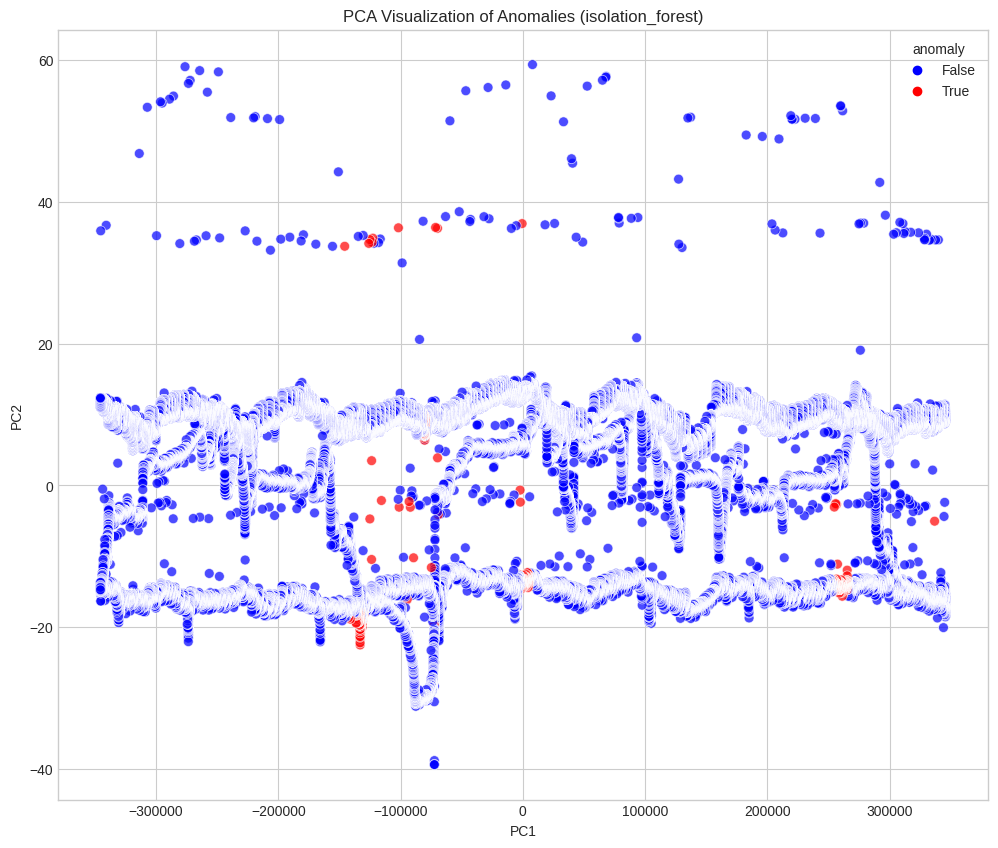

Explained variance ratio: [9.99999997e-01 3.27768955e-09]
Total explained variance: 100.00%

Analyzing anomalies detected by isolation_forest...

Basic statistics for normal data:
                 ts             co       humidity            lpg  \
count  4.011340e+05  401134.000000  401134.000000  401134.000000   
mean   1.594859e+09       0.004603      60.389103       0.007201   
std    1.995892e+05       0.001158      11.336124       0.001362   
min    1.594512e+09       0.001197       1.100000       0.002738   
25%    1.594688e+09       0.003919      51.000000       0.006456   
50%    1.594860e+09       0.004797      54.700000       0.007472   
75%    1.595032e+09       0.005376      74.300003       0.008115   
max    1.595203e+09       0.007909      99.900002       0.010729   

               smoke           temp  
count  401134.000000  401134.000000  
mean        0.019159      22.488215  
std         0.003842       2.686834  
min         0.006809       0.000000  
25%         0.017

In [ ]:
# Environmental Sensor Anomaly Detection
# Based on: https://www.kaggle.com/datasets/garystafford/environmental-sensor-data-132k

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

class EnvSensorAnomalyDetector:
    """Environmental Sensor Anomaly Detection System for Kaggle Dataset"""
    
    def __init__(self, contamination=0.01):
        """
        Initialize the detector with configurable parameters
        
        Args:
            contamination: Expected proportion of anomalies in the data
        """
        self.contamination = contamination
        self.models = {}
        self.scalers = {}
        self.anomalies = {}
        self.pca_model = None
        self.features = None
    
    def load_data(self, filepath, parse_dates=True):
        """Load the environmental sensor dataset"""
        print(f"Loading data from {filepath}...")
        
        # Load dataset
        self.df = pd.read_csv(filepath, parse_dates=parse_dates)
        
        # Display basic information
        print(f"Dataset loaded successfully: {self.df.shape[0]} records with {self.df.shape[1]} columns")
        print("\nSample data:")
        print(self.df.head())
        
        # Show data types and missing values
        print("\nData types and missing values:")
        print(self.df.info())
        print("\nMissing values by column:")
        print(self.df.isnull().sum())
        
        return self.df
    
    def preprocess_data(self):
        """Preprocess the environmental sensor data"""
        print("\nPreprocessing data...")
        
        # Make a copy of the original dataframe
        df = self.df.copy()
        
        # Convert timestamp to datetime if it's not already
        if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            print("Converted timestamp to datetime")
        
        # Handle missing values
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        print(f"Filled missing values in {len(numeric_cols)} numeric columns")
        
        # Extract temporal features if timestamp exists
        if 'timestamp' in df.columns:
            df['hour'] = df['timestamp'].dt.hour
            df['day'] = df['timestamp'].dt.day
            df['day_of_week'] = df['timestamp'].dt.dayofweek
            df['month'] = df['timestamp'].dt.month
            print("Created temporal features (hour, day, day_of_week, month)")
        
        # Store the preprocessed data
        self.processed_df = df
        
        # Identify numeric features for anomaly detection
        self.numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        
        # Remove temporal features from numeric_features if they exist
        self.features = [col for col in self.numeric_features 
                        if col not in ['hour', 'day', 'day_of_week', 'month']]
        
        print(f"Selected {len(self.features)} features for anomaly detection: {self.features}")
        
        return self.processed_df
    
    def exploratory_analysis(self, n_sensors=5):
        """Perform exploratory data analysis on the sensor data"""
        print("\nPerforming exploratory data analysis...")
        
        # Choose a subset of features to analyze
        if len(self.features) > n_sensors:
            analysis_features = self.features[:n_sensors]
        else:
            analysis_features = self.features
            
        # Plot histograms of sensor readings
        plt.figure(figsize=(15, 10))
        for i, feature in enumerate(analysis_features, 1):
            plt.subplot(n_sensors, 2, i)
            self.processed_df[feature].hist(bins=50)
            plt.title(f'Distribution of {feature}')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
        
        # Plot time series if timestamp exists
        if 'timestamp' in self.processed_df.columns:
            plt.figure(figsize=(15, 10))
            for i, feature in enumerate(analysis_features, 1):
                plt.subplot(len(analysis_features), 1, i)
                plt.plot(self.processed_df['timestamp'], self.processed_df[feature])
                plt.title(f'Time Series of {feature}')
                plt.ylabel('Value')
            plt.tight_layout()
            plt.show()
        
        # Correlation matrix
        plt.figure(figsize=(12, 10))
        corr = self.processed_df[self.features].corr()
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                   vmin=-1, vmax=1, linewidths=0.5)
        plt.title('Correlation Matrix of Sensor Features')
        plt.show()
        
        # Basic statistics
        print("\nBasic statistics of sensor features:")
        print(self.processed_df[self.features].describe())
        
        return corr
    
    def detect_anomalies_isolation_forest(self):
        """Detect anomalies using Isolation Forest algorithm"""
        print("\nDetecting anomalies with Isolation Forest...")
        
        # Prepare data for anomaly detection
        X = self.processed_df[self.features].copy()
        
        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        self.scalers['global'] = scaler
        
        # Train the Isolation Forest model
        model = IsolationForest(
            contamination=self.contamination,
            random_state=42,
            n_estimators=100,
            n_jobs=-1
        )
        
        # Fit and predict
        model.fit(X_scaled)
        self.models['isolation_forest'] = model
        
        # Get anomaly scores (-1 for anomalies, 1 for normal data)
        y_pred = model.predict(X_scaled)
        
        # Get decision scores (lower values indicate anomalous behavior)
        scores = model.decision_function(X_scaled)
        
        # Add results to processed dataframe
        self.processed_df['anomaly_isolation_forest'] = y_pred == -1
        self.processed_df['anomaly_score_isolation_forest'] = scores
        
        # Store anomalies
        self.anomalies['isolation_forest'] = self.processed_df[self.processed_df['anomaly_isolation_forest']]
        
        print(f"Detected {len(self.anomalies['isolation_forest'])} anomalies ({self.anomalies['isolation_forest'].shape[0]/self.processed_df.shape[0]:.2%} of data)")
        
        return self.anomalies['isolation_forest']
    
    def detect_anomalies_dbscan(self, eps=0.5, min_samples=5):
        """Detect anomalies using DBSCAN clustering algorithm"""
        print("\nDetecting anomalies with DBSCAN...")
        
        # Prepare data for anomaly detection
        X = self.processed_df[self.features].copy()
        
        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        self.scalers['dbscan'] = scaler
        
        # Apply PCA for dimensionality reduction if we have many features
        if len(self.features) > 10:
            print("Applying PCA before DBSCAN...")
            pca = PCA(n_components=min(10, len(self.features)))
            X_pca = pca.fit_transform(X_scaled)
            self.pca_model = pca
            input_data = X_pca
        else:
            input_data = X_scaled
        
        # Apply DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        clusters = dbscan.fit_predict(input_data)
        
        # Store the model
        self.models['dbscan'] = dbscan
        
        # Add results to processed dataframe
        self.processed_df['cluster_dbscan'] = clusters
        self.processed_df['anomaly_dbscan'] = clusters == -1
        
        # Store anomalies
        self.anomalies['dbscan'] = self.processed_df[self.processed_df['anomaly_dbscan']]
        
        print(f"Detected {len(self.anomalies['dbscan'])} anomalies ({self.anomalies['dbscan'].shape[0]/self.processed_df.shape[0]:.2%} of data)")
        
        # Calculate silhouette score for non-anomalous points
        if len(set(clusters)) > 1 and -1 in clusters and sum(clusters != -1) > 1:
            try:
                non_anomaly_idx = clusters != -1
                silhouette = silhouette_score(input_data[non_anomaly_idx], clusters[non_anomaly_idx])
                print(f"Silhouette score: {silhouette:.4f}")
            except:
                print("Couldn't calculate silhouette score")
        
        return self.anomalies['dbscan']
    
    def compare_methods(self):
        """Compare different anomaly detection methods"""
        if not ('anomaly_isolation_forest' in self.processed_df.columns and 
                'anomaly_dbscan' in self.processed_df.columns):
            print("Run both isolation forest and DBSCAN anomaly detection first")
            return
        
        print("\nComparing anomaly detection methods...")
        
        # Create a comparison table
        comparison = pd.DataFrame({
            'Method': ['Isolation Forest', 'DBSCAN'],
            'Anomalies Detected': [
                self.processed_df['anomaly_isolation_forest'].sum(),
                self.processed_df['anomaly_dbscan'].sum()
            ],
            'Percentage': [
                self.processed_df['anomaly_isolation_forest'].mean() * 100,
                self.processed_df['anomaly_dbscan'].mean() * 100
            ]
        })
        
        # Calculate agreement between methods
        agreement = (self.processed_df['anomaly_isolation_forest'] & 
                     self.processed_df['anomaly_dbscan']).sum()
        
        total_anomalies = (self.processed_df['anomaly_isolation_forest'] | 
                          self.processed_df['anomaly_dbscan']).sum()
        
        # Add to the comparison table
        comparison = comparison.append({
            'Method': 'Common Anomalies',
            'Anomalies Detected': agreement,
            'Percentage': (agreement / total_anomalies * 100) if total_anomalies > 0 else 0
        }, ignore_index=True)
        
        print(comparison)
        
        # Create a Venn diagram of the anomalies
        try:
            from matplotlib_venn import venn2
            plt.figure(figsize=(10, 6))
            venn2(subsets=(
                self.processed_df['anomaly_isolation_forest'].sum() - agreement,
                self.processed_df['anomaly_dbscan'].sum() - agreement,
                agreement
            ), set_labels=('Isolation Forest', 'DBSCAN'))
            plt.title('Overlap in Anomalies Detected')
            plt.show()
        except ImportError:
            print("matplotlib_venn not available for Venn diagram")
        
        return comparison
    
    def visualize_anomalies(self, method='isolation_forest', n_features=3):
        """Visualize the detected anomalies"""
        print(f"\nVisualizing anomalies detected by {method}...")
        
        anomaly_col = f'anomaly_{method}'
        if anomaly_col not in self.processed_df.columns:
            print(f"Run {method} anomaly detection first")
            return
        
        # Select top features based on the anomaly distribution difference
        feature_importance = {}
        for feature in self.features:
            normal_mean = self.processed_df[~self.processed_df[anomaly_col]][feature].mean()
            anomaly_mean = self.processed_df[self.processed_df[anomaly_col]][feature].mean()
            feature_importance[feature] = abs(normal_mean - anomaly_mean)
        
        # Sort features by importance
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
        top_features = [f[0] for f in sorted_features[:n_features]]
        
        print(f"Top discriminative features: {top_features}")
        
        # Plot time series with anomalies highlighted if timestamp exists
        if 'timestamp' in self.processed_df.columns:
            plt.figure(figsize=(15, n_features * 3))
            for i, feature in enumerate(top_features, 1):
                plt.subplot(n_features, 1, i)
                
                # Plot normal data
                plt.plot(
                    self.processed_df.loc[~self.processed_df[anomaly_col], 'timestamp'],
                    self.processed_df.loc[~self.processed_df[anomaly_col], feature],
                    'b.', alpha=0.5, label='Normal'
                )
                
                # Plot anomalies
                plt.plot(
                    self.processed_df.loc[self.processed_df[anomaly_col], 'timestamp'],
                    self.processed_df.loc[self.processed_df[anomaly_col], feature],
                    'r*', markersize=10, label='Anomaly'
                )
                
                plt.title(f'{feature} Over Time')
                plt.ylabel('Value')
                if i == n_features:  # Only add x-label for the bottom plot
                    plt.xlabel('Timestamp')
                plt.legend()
            
            plt.tight_layout()
            plt.show()
        
        # Plot 2D visualization if we have at least 2 features
        if len(top_features) >= 2:
            plt.figure(figsize=(12, 10))
            
            plt.scatter(
                self.processed_df.loc[~self.processed_df[anomaly_col], top_features[0]],
                self.processed_df.loc[~self.processed_df[anomaly_col], top_features[1]],
                c='blue', label='Normal', alpha=0.5
            )
            
            plt.scatter(
                self.processed_df.loc[self.processed_df[anomaly_col], top_features[0]],
                self.processed_df.loc[self.processed_df[anomaly_col], top_features[1]],
                c='red', label='Anomaly', alpha=1.0
            )
            
            plt.title(f'{top_features[0]} vs {top_features[1]} with Anomalies')
            plt.xlabel(top_features[0])
            plt.ylabel(top_features[1])
            plt.legend()
            plt.grid(True)
            plt.show()
        
        # Distribution of anomaly scores if available
        score_col = f'anomaly_score_{method}'
        if score_col in self.processed_df.columns:
            plt.figure(figsize=(12, 6))
            sns.histplot(self.processed_df[score_col], bins=50, kde=True)
            plt.axvline(x=0, color='r', linestyle='--')
            plt.title(f'Distribution of Anomaly Scores ({method})')
            plt.xlabel('Anomaly Score')
            plt.ylabel('Frequency')
            plt.show()
        
        # PCA visualization for high-dimensional data
        if len(self.features) > 2:
            print("Generating PCA visualization...")
            
            # Apply PCA
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(self.processed_df[self.features])
            
            # Create a DataFrame with PCA results
            pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
            pca_df['anomaly'] = self.processed_df[anomaly_col].values
            
            # Plot PCA results
            plt.figure(figsize=(12, 10))
            sns.scatterplot(
                data=pca_df, x='PC1', y='PC2', 
                hue='anomaly', palette={True: 'red', False: 'blue'},
                alpha=0.7, s=50
            )
            plt.title(f'PCA Visualization of Anomalies ({method})')
            plt.grid(True)
            plt.show()
            
            # Show explained variance
            print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
            print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")
        
        return top_features
    
    def analyze_anomalies(self, method='isolation_forest'):
        """Analyze properties of detected anomalies"""
        print(f"\nAnalyzing anomalies detected by {method}...")
        
        anomaly_col = f'anomaly_{method}'
        if anomaly_col not in self.processed_df.columns:
            print(f"Run {method} anomaly detection first")
            return
        
        # Extract anomalies
        anomalies = self.processed_df[self.processed_df[anomaly_col]].copy()
        
        if anomalies.empty:
            print("No anomalies detected to analyze")
            return
        
        # Basic statistics of anomalies vs normal data
        print("\nBasic statistics for normal data:")
        print(self.processed_df[~self.processed_df[anomaly_col]][self.features].describe())
        
        print("\nBasic statistics for anomalies:")
        print(anomalies[self.features].describe())
        
        # Calculate and display the percentage difference between normal and anomalous data
        normal_mean = self.processed_df[~self.processed_df[anomaly_col]][self.features].mean()
        anomaly_mean = anomalies[self.features].mean()
        
        percent_diff = ((anomaly_mean - normal_mean) / normal_mean * 100).abs().sort_values(ascending=False)
        
        print("\nFeatures with the largest percentage difference between normal and anomalous data:")
        print(percent_diff)
        
        # Temporal distribution of anomalies if timestamp exists
        if 'timestamp' in self.processed_df.columns:
            # Group by day and count anomalies
            if 'timestamp' in anomalies.columns:
                anomalies['date'] = anomalies['timestamp'].dt.date
                anomaly_counts = anomalies.groupby('date').size()
                
                plt.figure(figsize=(15, 6))
                anomaly_counts.plot(kind='bar')
                plt.title('Number of Anomalies by Date')
                plt.xlabel('Date')
                plt.ylabel('Count')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            
            # Distribution by hour of day if available
            if 'hour' in anomalies.columns:
                plt.figure(figsize=(12, 6))
                sns.countplot(x='hour', data=anomalies)
                plt.title('Anomalies by Hour of Day')
                plt.xlabel('Hour')
                plt.ylabel('Count')
                plt.grid(True, axis='y')
                plt.show()
        
        return anomalies
    
    def save_results(self, output_path='anomaly_results.csv'):
        """Save the anomaly detection results to a CSV file"""
        print(f"\nSaving results to {output_path}...")
        
        # Create a copy of the processed dataframe with selected columns
        result_df = self.processed_df.copy()
        
        # Keep only essential columns
        if 'timestamp' in result_df.columns:
            essential_cols = ['timestamp']
        else:
            essential_cols = []
            
        # Add feature columns
        essential_cols.extend(self.features)
        
        # Add anomaly columns
        anomaly_cols = [col for col in result_df.columns if 'anomaly' in col]
        essential_cols.extend(anomaly_cols)
        
        # Filter columns that exist in the dataframe
        existing_cols = [col for col in essential_cols if col in result_df.columns]
        result_df = result_df[existing_cols]
        
        # Save to CSV
        result_df.to_csv(output_path, index=False)
        print(f"Results saved successfully with {len(existing_cols)} columns and {len(result_df)} rows")
        
        return result_df

# Example usage for a Kaggle notebook
def run_environmental_sensor_analysis(data_path):
    """Run the full environmental sensor anomaly detection pipeline"""
    
    # Create detector
    detector = EnvSensorAnomalyDetector(contamination=0.01)
    
    # Load and preprocess data
    detector.load_data(data_path)
    detector.preprocess_data()
    
    # Run exploratory analysis
    detector.exploratory_analysis()
    
    # Detect anomalies using Isolation Forest
    detector.detect_anomalies_isolation_forest()
    
    # Visualize anomalies
    detector.visualize_anomalies(method='isolation_forest')
    
    # Analyze anomalies in depth
    detector.analyze_anomalies(method='isolation_forest')
    
    # Try DBSCAN with different parameters
    detector.detect_anomalies_dbscan(eps=0.5, min_samples=5)
    
    # Compare methods
    detector.compare_methods()
    
    # Save results
    detector.save_results()
    
    return detector

# This will be the entry point when running in a Kaggle notebook
if __name__ == "__main__":
    # Path to the dataset
    DATA_PATH = "/kaggle/input/environmental-sensor-data-132k/iot_telemetry_data.csv"
    
    # Run the analysis
    detector = run_environmental_sensor_analysis(DATA_PATH)